In [1]:
# imports
import os
import numpy as np

# pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms

# libs for image processing
from PIL import Image

# dataset 
from datasets import load_dataset
import pandas as pd

# splitting training data
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

### Data Exploration

In [2]:
# loading in dataset
dataset = load_dataset("svhn", "cropped_digits")

In [3]:
#splitting train and test
total_data = dataset['extra']

#laoding into pandas
total_df = pd.DataFrame.from_dict(total_data)

In [4]:
# get total number of occurrences of each digit
total_df['label'].value_counts()

label
1    90560
2    74740
3    60765
5    53490
4    50633
0    45550
7    43997
6    41582
8    35358
9    34456
Name: count, dtype: int64

In [5]:
def get_image_sizes(dataset):

    for i in range(5):
        # Get the size of the image
        img = dataset[i]
        width, height = img.size

        print(f"Image: {i}")
        print(f"Width: {width}")
        print(f"Height: {height}")

get_image_sizes(total_df['image'])

Image: 0
Width: 32
Height: 32
Image: 1
Width: 32
Height: 32
Image: 2
Width: 32
Height: 32
Image: 3
Width: 32
Height: 32
Image: 4
Width: 32
Height: 32


#### Calculating Mean and Std to use w/ data normalization transform

In [6]:
# separating features and labels
X_total = total_df['image']
y_total = total_df['label']

In [7]:
# checking dataset length
print(X_total.__len__())
print(y_total.__len__())

531131
531131


In [8]:
# defining transform and applying it to images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Apply transform to each image in X_total
X_total_transformed = torch.stack([transform(img) for img in X_total])

# Convert y_total to tensor
y_total_transformed = torch.tensor(y_total.values)

# Create the total dataset
total_dataset = TensorDataset(X_total_transformed, y_total_transformed)

In [9]:
def compute_mean_std(dataset, batch_size=32, num_workers=0):
    """Compute the mean and std value of dataset"""
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = 0
    print('Computing mean and std...')
    for images, _ in data_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples
    mean /= n_samples
    std /= n_samples
    return mean, std

computed_mean , computed_std = compute_mean_std(total_dataset)

Computing mean and std...


### Preparing Training, Validation and Testing Data

In [10]:
# split dataset into train and test
train_data = dataset['train']
test_data = dataset['test']

# laad dataset into pandas df
train_df = pd.DataFrame.from_dict(train_data)
test_df = pd.DataFrame.from_dict(test_data)

In [11]:
# creating the total dataset
train_dataset = TensorDataset(X_total_transformed, y_total_transformed)

In [12]:
# split train data
X = train_df['image']
y = train_df['label']

#splitting trining set into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# testing data 
X_test = test_df['image']
y_test = test_df['label']

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(computed_std, computed_mean)
])

In [14]:
# Apply transform to each image in X_train
X_train_transformed = torch.stack([transform(img) for img in X_train])
y_train_transformed = torch.tensor(y_train.values)


# Apply transform to each image in X_val
X_val_transformed = torch.stack([transform(img) for img in X_val])
y_val_transformed = torch.tensor(y_val.values)

# Apply transform to each image in X_test
X_test_transformed = torch.stack([transform(img) for img in X_test])
y_test_transformed = torch.tensor(y_test.values)

In [15]:
# getting number of occurrences of each digit
print(f"Value count for train_df: {train_df['label'].value_counts()}")
print(f"Value count for test_df: {test_df['label'].value_counts()}")

Value count for train_df: label
1    13861
2    10585
3     8497
4     7458
5     6882
6     5727
7     5595
8     5045
0     4948
9     4659
Name: count, dtype: int64
Value count for test_df: label
1    5099
2    4149
3    2882
4    2523
5    2384
7    2019
6    1977
0    1744
8    1660
9    1595
Name: count, dtype: int64


#### Creating augmented images to balance out dataset

In [16]:
# Define transformation functions
# Transformation for classes 0 and 8
transform_0_8 = transforms.Compose([
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),  # Converts to Tensor and normalizes to [0, 1]
])

# Transformation for all other classes (non flipping horizontal and vertical)
transform_other = transforms.Compose([
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Function to generate augmented samples
def generate_augmented_samples(images, labels, target_class, target_count):
    augmented_images = []
    augmented_labels = []

    # Choose the appropriate transformation based on the target class
    transform = transform_0_8 if target_class in [0, 8] else transform_other
    
    for img, label in zip(images, labels):
        if label == target_class and len(augmented_images) < target_count:
            # Apply the chosen transformation
            aug_img = transform(img)
            augmented_images.append(aug_img)
            augmented_labels.append(label)

    return torch.stack(augmented_images), torch.tensor(augmented_labels)

In [17]:
# Generate augmented samples for the underrepresented class 
aug_X_train_0, aug_y_train_0 = generate_augmented_samples(X_train, y_train, 0, 8500)
aug_X_train_2, aug_y_train_2 = generate_augmented_samples(X_train, y_train, 2, 3000)
aug_X_train_3, aug_y_train_3 = generate_augmented_samples(X_train, y_train, 3, 5000)
aug_X_train_4, aug_y_train_4 = generate_augmented_samples(X_train, y_train, 4, 6000)
aug_X_train_5, aug_y_train_5 = generate_augmented_samples(X_train, y_train, 5, 6700)
aug_X_train_6, aug_y_train_6 = generate_augmented_samples(X_train, y_train, 6, 8000)
aug_X_train_7, aug_y_train_7 = generate_augmented_samples(X_train, y_train, 7, 8500)
aug_X_train_8, aug_y_train_8 = generate_augmented_samples(X_train, y_train, 8, 9000)
aug_X_train_9, aug_y_train_9 = generate_augmented_samples(X_train, y_train, 9, 9000)

# Combine the original and augmented samples
X_train_transformed = torch.cat([X_train_transformed, aug_X_train_0, aug_X_train_2, aug_X_train_3, aug_X_train_4, aug_X_train_5, aug_X_train_6, aug_X_train_7, aug_X_train_8, aug_X_train_9], dim=0)
y_train_transformed = torch.cat([y_train_transformed, aug_y_train_0, aug_y_train_2, aug_y_train_3, aug_y_train_4, aug_y_train_5, aug_y_train_6, aug_y_train_7, aug_y_train_8, aug_y_train_9], dim=0)

In [18]:
# checking new len
print(X_train_transformed.__len__())
print(y_train_transformed.__len__())

98918
98918


In [19]:
# Create the train dataset
train_dataset = TensorDataset(X_train_transformed, y_train_transformed)
# Create the val dataset
val_dataset = TensorDataset(X_val_transformed, y_val_transformed)
# Create the test dataset
test_dataset = TensorDataset(X_test_transformed, y_test_transformed)

In [20]:
# create dataloader objs
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

### Overview of CNN Class

1. **Convolutional Layers**:
   - For the first convolutional layer (`self.conv1`), I chose `in_channels=3` because the input images are expected to have 3 color channels (RGB). I set `out_channels=32` to learn a reasonable number of feature maps in the initial layer, capturing low-level features like edges and textures.
   - I opted for a `kernel_size=5` in the first layer to capture larger patterns and spatial relationships, which is common practice for early layers in CNNs. The `padding=2` ensures that the spatial dimensions are preserved after convolution, which helps maintain important spatial information.
   - In the second convolutional layer (`self.conv2`), I increased the number of `out_channels` to 64 to learn more complex and higher-level features. I chose a smaller `kernel_size=3` to capture finer details and patterns, as deeper layers typically focus on more granular features.
   - The `padding=1` in the second layer also helps preserve spatial dimensions, which is crucial for maintaining important spatial information throughout the network.

2. **Batch Normalization Layers**:
   - I included batch normalization layers (`self.bn1` and `self.bn2`) after each convolutional layer to improve the training stability and convergence of the network. Batch normalization helps mitigate the internal covariate shift problem, allowing for higher learning rates and better generalization.

3. **Activation Functions**:
   - I chose to use the Leaky ReLU activation function (`self.relu1` and `self.relu2`) with a `negative_slope=0.01` for both convolutional layers. Leaky ReLU addresses the "dying ReLU" problem by introducing a small negative slope for negative inputs, preventing neurons from becoming inactive during training.
   - The value of `negative_slope=0.01` is a common choice that has shown good performance in various applications, allowing a small non-linearity for negative inputs while still maintaining the benefits of ReLU's sparsity.

4. **Pooling Layers**:
   - I incorporated max pooling layers (`self.pool1` and `self.pool2`) with `kernel_size=2` and `stride=2` to downsample the spatial dimensions of the feature maps after each convolutional layer.

5. **Fully Connected Layers**:
   - For the first fully connected layer (`self.fc1`), I dynamically calculated the number of input features (`in_features`) using the `to_linear` helper function. This ensures that the flattened output from the convolutional layers is correctly reshaped for the fully connected layer, regardless of the input image size or the convolutional layer configurations.
   - I chose `out_features=256` for the first fully connected layer to provide a reasonable number of units for learning higher-level features and representations from the convolutional layers.
   - For the final fully connected layer (`self.fc2`), I set `out_features=10` as the task is a digit classification problem with 10 output classes. This layer produces the final class predictions.

6. **Batch Normalization and Dropout**:
   - I included a batch normalization layer (`self.bn3`) after the first fully connected layer to further improve training stability and convergence for the fully connected part of the network.
   - To prevent overfitting, I added a dropout layer (`self.dropout1`) with a drop probability of `p=0.5` after the first fully connected layer.

7. **Activation Function for Fully Connected Layers**:
   - Consistent with the convolutional layers, I chose to use the Leaky ReLU activation function (`self.relu3`) with `negative_slope=0.01` for the fully connected layers as well. This non-linearity helps the network learn complex representations and mappings from the input data to the output classes.

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the correct number of features dynamically
        self.fc1 = nn.Linear(in_features=self.to_linear(3, 32, 32), out_features=256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def to_linear(self, channels, height, width):
        # Helper to automatically calculate the input features for the first fully connected layer
        x = torch.randn((1, channels, height, width))
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        return int(x.numel() / x.shape[0])
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        
        return x

### Cuda Setup

In [22]:
# Check Cuda is available
torch.cuda.is_available()

True

In [23]:
device = torch.device('cuda:0')

### Model Training and Eval

#### Creating Plotting Fxns

In [24]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_confusion_matrix(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


#### Training the model

In [26]:
# creating early stopping class to stop model training after val accuracy stops decreasing and save model params

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta
        self.path = path

    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model)
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.4f} --> {val_acc:.4f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc

In [27]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device, checkpoint_dir='./checkpoints'):
    # Initialize lists to store losses and accuracies for each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=10, verbose=True, path=os.path.join(checkpoint_dir, 'best_model.pt'))

    # Create the checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_acc = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            train_acc += (y_pred.argmax(1) == y).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item() * X.size(0)
                val_acc += (y_pred.argmax(1) == y).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model based on validation accuracy
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model back
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pt')))
    return train_losses, train_accuracies, val_losses, val_accuracies

#### Model Evaluation

In [28]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += torch.nn.functional.cross_entropy(y_pred, y, reduction='sum').item()  # sum up batch loss
            correct += (y_pred.argmax(1) == y).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy

In [29]:
def evaluate_model_f1(model, test_loader, device):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Lists to store true and predicted labels
    true_labels = []
    pred_labels = []
    
    # Disable gradient calculation for efficiency and to reduce memory usage
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the device the model is on
            data, target = data.to(device), target.to(device)
            
            # Get the model output
            outputs = model(data)
            
            # Convert output probabilities to predicted class
            _, preds = torch.max(outputs, 1)
            
            # Extend the lists with the true and predicted labels
            true_labels.extend(target.view(-1).cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    
    # Return the metrics
    return precision, recall, f1

#### Training Model

In [30]:
# init model and send to GPU
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [31]:
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [32]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, optimizer, criterion, train_loader, val_loader, epochs, device)

Epoch [1/1000], Train Loss: 0.7731, Train Acc: 0.7529, Val Loss: 0.4170, Val Acc: 0.8752
Validation accuracy increased (0.0000 --> 0.8752). Saving model ...
Epoch [2/1000], Train Loss: 0.5192, Train Acc: 0.8381, Val Loss: 0.3328, Val Acc: 0.9014
Validation accuracy increased (0.8752 --> 0.9014). Saving model ...
Epoch [3/1000], Train Loss: 0.4358, Train Acc: 0.8634, Val Loss: 0.3126, Val Acc: 0.9094
Validation accuracy increased (0.9014 --> 0.9094). Saving model ...
Epoch [4/1000], Train Loss: 0.3882, Train Acc: 0.8784, Val Loss: 0.3251, Val Acc: 0.9039
EarlyStopping counter: 1 out of 10
Epoch [5/1000], Train Loss: 0.3543, Train Acc: 0.8885, Val Loss: 0.3001, Val Acc: 0.9149
Validation accuracy increased (0.9094 --> 0.9149). Saving model ...
Epoch [6/1000], Train Loss: 0.3220, Train Acc: 0.8988, Val Loss: 0.2818, Val Acc: 0.9193
Validation accuracy increased (0.9149 --> 0.9193). Saving model ...
Epoch [7/1000], Train Loss: 0.2996, Train Acc: 0.9056, Val Loss: 0.2829, Val Acc: 0.9214
Va

#### Eval Model

In [33]:
test_loss, test_accuracy = evaluate_model(model, test_loader, device)

Test Loss: 0.3603, Test Accuracy: 0.9194


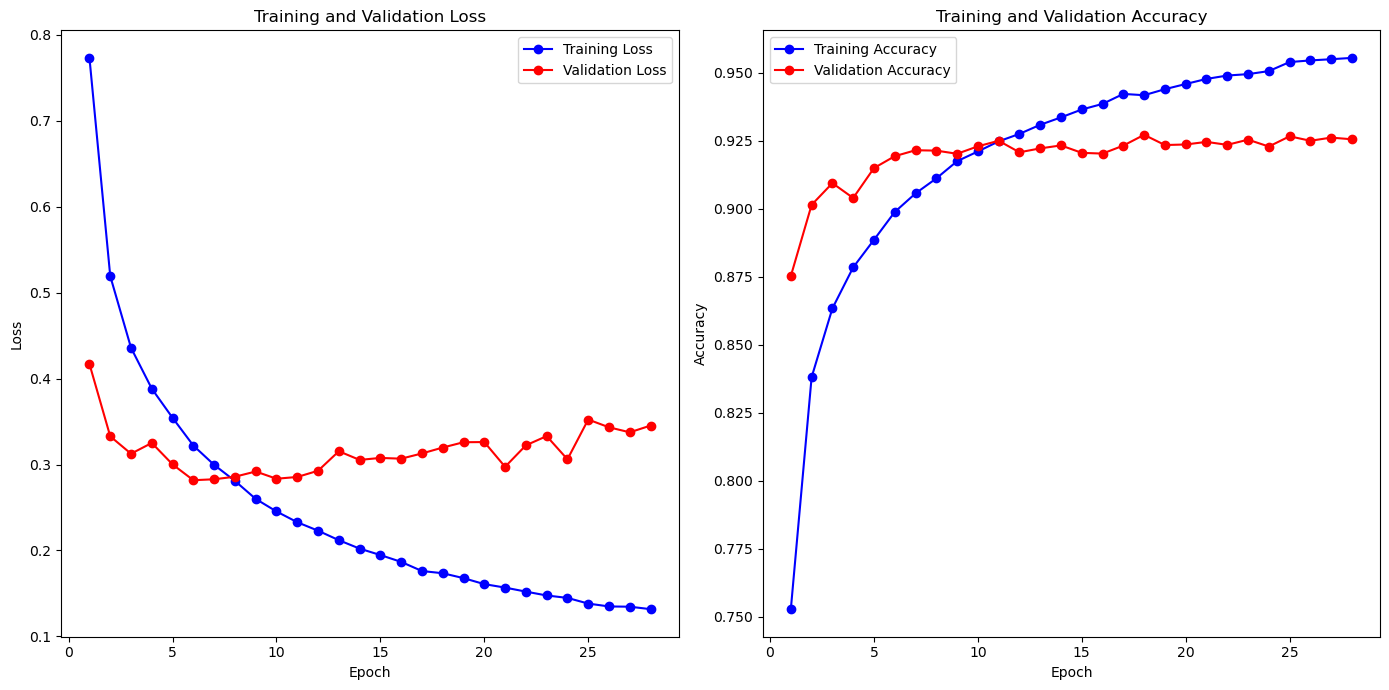

In [34]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

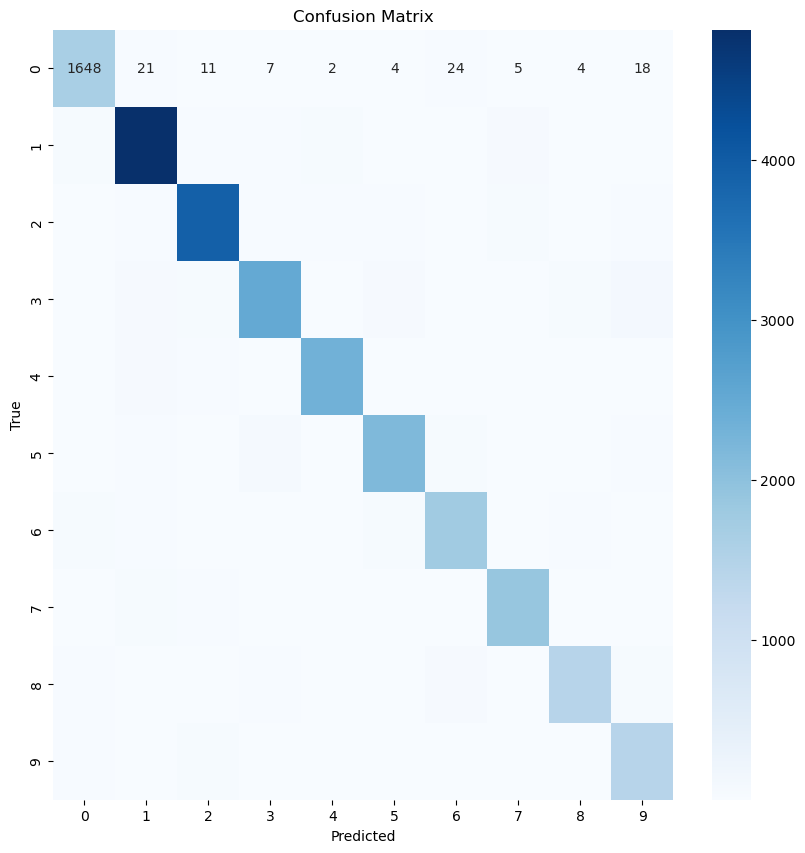

In [35]:
plot_confusion_matrix(model, test_loader, device, classes)

In [36]:
precision, recall, f1 = evaluate_model_f1(model, test_loader, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9198
Recall: 0.9194
F1 Score: 0.9193
